In [17]:
import numpy as np 
import scipy as sp 
import matplotlib.pyplot as plt
import pandas as pd
from osc_toolkit import oscillation, delayed_oscillation
from models import *
import matplotlib.patches as patches

In [5]:
params = [24.30616411,  1.1391591,   3.08829181, 10.66927823]
consts = [0.17, 4]
init_cond = [0.1, 0]
osc_MHNatChem = oscillation(approx_model_FTC, params, consts, init_cond, calc_all_approx_model_FTC)
osc_MHNatChem.add_info('Chemical oscillation in the Nature Chemistry paper, Michael Howlett, 3b')

(<Figure size 700x500 with 4 Axes>,
 array([[<Axes: xlabel='Normalized Time', ylabel='Normalized Concentration'>,
         <Axes: xlabel='Normalized Time', ylabel='Normalized Concentration'>],
        [<Axes: xlabel='Normalized Time', ylabel='Normalized Concentration'>,
         <Axes: xlabel='Normalized Time', ylabel='Normalized Concentration'>]],
       dtype=object))

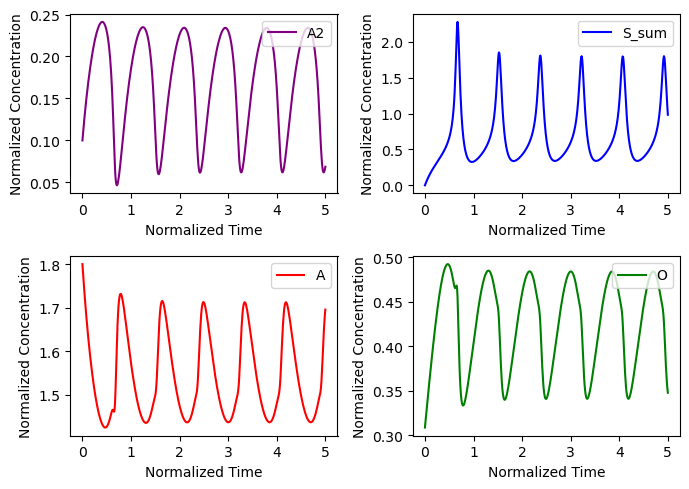

In [6]:
osc_MHNatChem.plot(t=5)

In [7]:
def rate_approx_model_FTC(vars, params, target=['S']):
    alpha, beta, theta, phi, lam, m = params
    cA2, cS = vars
    if 'S' in target:
        Sform_c = alpha/lam * cA2 * cS**m
        Sform_nc = theta/lam * cA2
        Sdecomp_c = beta * cS**(m + 1) 
        Sdecomp_nc = phi * cS
    
    #The changing rate of A2 can be added here if needed.
    
    return Sform_c, Sform_nc, Sdecomp_c, Sdecomp_nc

In [8]:
sol = osc_MHNatChem.simulate(t=3)

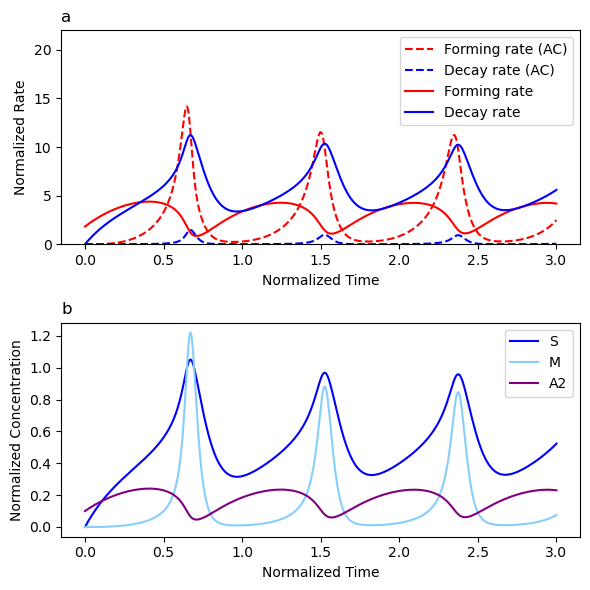

In [9]:
fig, ax = plt.subplots(2, 1, figsize=(6, 6))
ax1, ax2 = ax
sfc, sfnc, sdc, sdnc = rate_approx_model_FTC(sol.y, params+consts)
ax1.plot(sol.t, sfc, label='Forming rate (AC)', linestyle='--', color='r')
ax1.plot(sol.t, sdc, label='Decay rate (AC)', linestyle='--', color='b')
ax1.plot(sol.t, sfnc, label='Forming rate', color='r')
ax1.plot(sol.t, sdnc, label='Decay rate', color='b')
ax1.set_xlabel('Normalized Time')
ax1.set_ylabel('Normalized Rate')
ax1.set_title('a', loc='left')
ax1.set_ylim(0, 22)

ax2.plot(sol.t, sol.y[1], label='S', color='b')
ax2.plot(sol.t, sol.y[1]**4, label='M', color='lightskyblue')
ax2.plot(sol.t, sol.y[0], label='A2', color='purple')
ax2.set_xlabel('Normalized Time')
ax2.set_ylabel('Normalized Concentration')
ax2.set_title('b', loc='left')

ax1.legend(loc=1)
ax2.legend(loc=1)

plt.tight_layout()

# Rate decomposition of delayed model

In [10]:
files = [r'Data_sets/3a_fig3b_25_osc_NatChem_MH.csv', r'Data_sets/3a_fig3b_50_osc_NatChem_MH.csv', r'Data_sets/3a_fig3b_101_osc_NatChem_MH.csv']

df_MH_NatChem_fig3b_25, df_MH_NatChem_fig3b_50, df_MH_NatChem_fig3b_101 = [pd.read_csv(file) for file in files]
df_list = [df_MH_NatChem_fig3b_25, df_MH_NatChem_fig3b_50, df_MH_NatChem_fig3b_101]

cA2_tol = 14.5
CMC_3a = 1.56
tau = [2.1, 1, 0.52]

for tau, df in zip(tau, df_list):
    df['c3a'] /= CMC_3a
    df['Time'] /= tau
    df['t'] /= tau

In [12]:
params = np.array([33, 30, 0.5, 20])
consts = np.array([0.11, 2])
delay = np.array([0.01, 0.04])
init_cond = np.array([0.9, 0])
delayed_model_50 = delayed_oscillation(delayed_approx_model_FTC, delay, params, consts, init_cond, calc_all_delayed_approx_model_FTC)
delayed_model_50.add_exp_data(df_MH_NatChem_fig3b_50)

The species are ['A2', 'S_sum', 'A', 'O']. Please check if the data is in the same order and correct format (time, concentration).
Initial condition is set as [0.9 0. ]


In [20]:
sol50, t50 = delayed_model_50.simulate(t=3)

c:\Users\chem-sedm6967\AppData\Local\anaconda3\envs\jitcdde_clean_env\lib\site-packages\jitcdde\_jitcdde.py:324: UserWarning: The spline already contains points. This will remove them. Be sure that you really want this.
  self.past.constant(state,time)
c:\Users\chem-sedm6967\OneDrive - Nexus365\Desktop\01_projects\01_oscillation modelling\Chemical_Oscillation_Model\osc_toolkit.py:223: UserWarning: The target time is smaller than the current time. No integration step will happen. The returned state will be extrapolated from the interpolating Hermite polynomial for the last integration step. You may see this because you try to integrate backwards in time, in which case you did something wrong. You may see this just because your sampling step is small, in which case there is no need to worry (though you should think about increasing your sampling time).
  sol = np.array([self.dde.integrate(time) for time in t_eval])


In [21]:
def calc_rates(time, sol, delays, history, params, consts, details=False):
    alpha, beta, theta, phi = params
    lam, m = consts
    cA2 = sol[:, 0]
    cS = sol[:, 1]
    td1, td2 = delays
    cA2_past, cS_past = history
    def cA2_delayed(t, td):
        return cA2_past if t <= 0 else np.interp(t - td, time, cA2)
    def cS_delayed(t, td):
        return cS_past if t <= 0 else np.interp(t - td, time, cS)
    
    cS_td1 = np.array([cS_delayed(t, td1) for t in time])
    cS_td2 = np.array([cS_delayed(t, td2) for t in time])

    dcA2dt = 1 - alpha * cA2 * cS_td2**m - theta * cA2
    dcSdt = alpha/lam * cA2 * cS_td2**m - beta * cS_td1**m + theta/lam * cA2 - phi * cS
    rf_ac = alpha/lam * cA2 * cS_td2**m
    rf = theta/lam * cA2
    rde_ac = beta * cS_td1**m
    rde = phi * cS
    if details:
        return time, rf_ac, rf, rde_ac, rde
    else:
        return time, dcA2dt, dcSdt

In [23]:
t, dcA2dt, dcSdt = calc_rates(t50, sol50, delay, init_cond, params, consts)

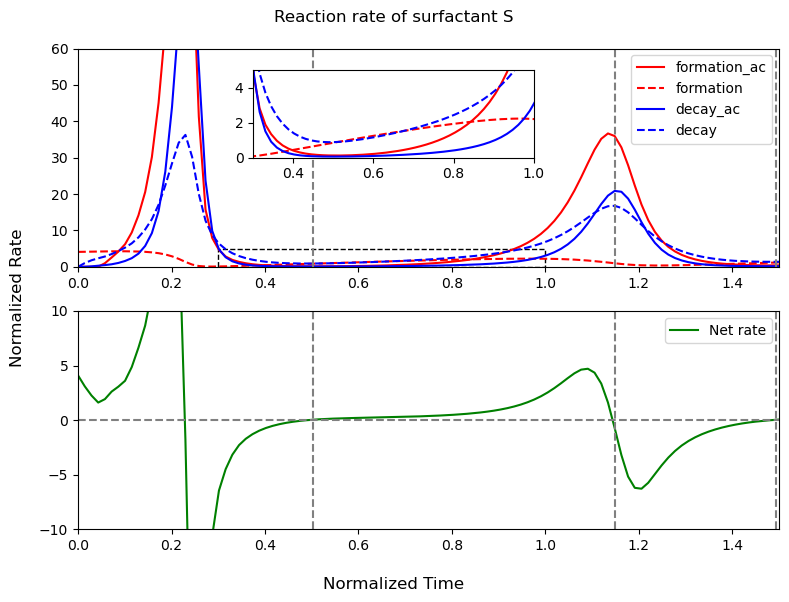

In [42]:
t, rf_ac, rf, rde_ac, rde = calc_rates(t50, sol50, delay, init_cond, params, consts, details=True)
fig, ax = plt.subplots(2, 1, figsize=(8, 6))
# Detailed rates plot
ax[0].plot(t, rf_ac, label='formation_ac', color='r')
ax[0].plot(t, rf, label='formation', color='r', linestyle='--')
ax[0].plot(t, rde_ac, label='decay_ac', color='b')
ax[0].plot(t, rde, label='decay', color='b', linestyle='--')
ax[0].legend(loc=1)
ax[0].set_ylim(0, 60)
ax[0].set_xlim(0, 1.5)

ax_inset = ax[0].inset_axes([0.25, 0.5, 0.4, 0.4])
for line in ax[0].lines:
    ax_inset.plot(line.get_xdata(), line.get_ydata(), color=line.get_color(), linestyle=line.get_linestyle())
ax_inset.set_xlim(0.3, 1.0)
ax_inset.set_ylim(0, 5)

rect = patches.Rectangle((0.3, 0), 0.7, 5, linewidth=1, edgecolor='black', facecolor='none', linestyle='--')
ax[0].add_patch(rect)

# Net rates plot
ax[1].plot(t, dcSdt, label='Net rate', color='g')
ax[1].set_xlim(0, 1.5)
ax[1].set_ylim(-10, 10)
ax[1].legend(loc=1)
ax[1].axhline(0, color='grey', linestyle='--')

sign_change = np.where(np.diff(np.sign(dcSdt)))[0]
for i in sign_change[1:4]:
    ax[0].axvline(t[i+1], color='grey', linestyle='--')
    ax[1].axvline(t[i+1], color='grey', linestyle='--')

fig.supxlabel('Normalized Time')
fig.supylabel('Normalized Rate')
fig.suptitle('Reaction rate of surfactant S')
fig.tight_layout()